In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.optimize import root
from scipy.stats import norm, truncnorm


SEED = 12345
phi = norm.pdf
Phi = norm.cdf

In [3]:
N = int(1e3)

rng = np.random.default_rng(SEED)

# distr = "GAUSS"
distr = "TRUNCGAUSS"
# distr = "BETA"

if distr == "GAUSS":
    mu = 0.
    sigma = 1.
    samples = rng.normal(loc=mu, scale=sigma, size=N)
    lower_bound = None
    upper_bound = None
elif distr == "TRUNCGAUSS":
    mu = 0.
    sigma = 1.
    lower_bound = -2.
    upper_bound = 2.
    samples = truncnorm((lower_bound - mu) / sigma, (upper_bound - mu) / sigma, loc=mu, scale=sigma).rvs(size=N, random_state=rng)
elif distr == "BETA":
    a = 5
    b = 5
    samples = rng.beta(a=a, b=b, size=N)
    mu = a / (a + b)
    sigma = 1 / (a + b) * np.sqrt(a * b / (a + b + 1))
    lower_bound = 0.
    upper_bound = 1.

In [4]:
def truncatedGaussianMLE(samples):
    lo_hat = np.min(samples)
    hi_hat = np.max(samples)

    def critical_point_mu(mu_hat, sigma_hat):
        alpha = (lo_hat - mu_hat) / sigma_hat
        beta = (hi_hat - mu_hat) / sigma_hat
        return np.mean(samples - mu_hat) + (phi(beta) - phi(alpha)) / (Phi(beta) - Phi(alpha))


    def critical_point_sigma(mu_hat, sigma_hat):
        alpha = (lo_hat - mu_hat) / sigma_hat
        beta = (hi_hat - mu_hat) / sigma_hat
        return np.mean((samples - mu_hat) ** 2) / sigma_hat ** 2 - 1 + (beta * phi(beta) - alpha * phi(alpha)) / (Phi(beta) - Phi(alpha))


    def objective(x):
        return np.array([critical_point_mu(x[0], x[1]), critical_point_sigma(x[0], x[1])])

    
    mu_hat_standard = np.mean(samples)
    sigma_hat_standard = np.std(samples)
    ret = root(objective, x0=[mu_hat_standard, sigma_hat_standard], method="hybr", tol=1e-3)
    if ret.success:
        return ret.x[0], ret.x[1], lo_hat, hi_hat
    else:
        return np.nan, np.nan, lo_hat, hi_hat

In [5]:
mu_hat_standard = []
sigma_hat_standard = []
mu_hat = []
sigma_hat = []
a = []
b = []

n_start = 5
for n in tqdm(range(n_start, N + 1)):
    mu_hat_standard.append(np.mean(samples[:n]))
    sigma_hat_standard.append(np.std(samples[:n]))
    ret = truncatedGaussianMLE(samples[:n])
    mu_hat.append(ret[0])
    sigma_hat.append(ret[1])
    a.append(ret[2])
    b.append(ret[3])

  0%|          | 0/996 [00:00<?, ?it/s]

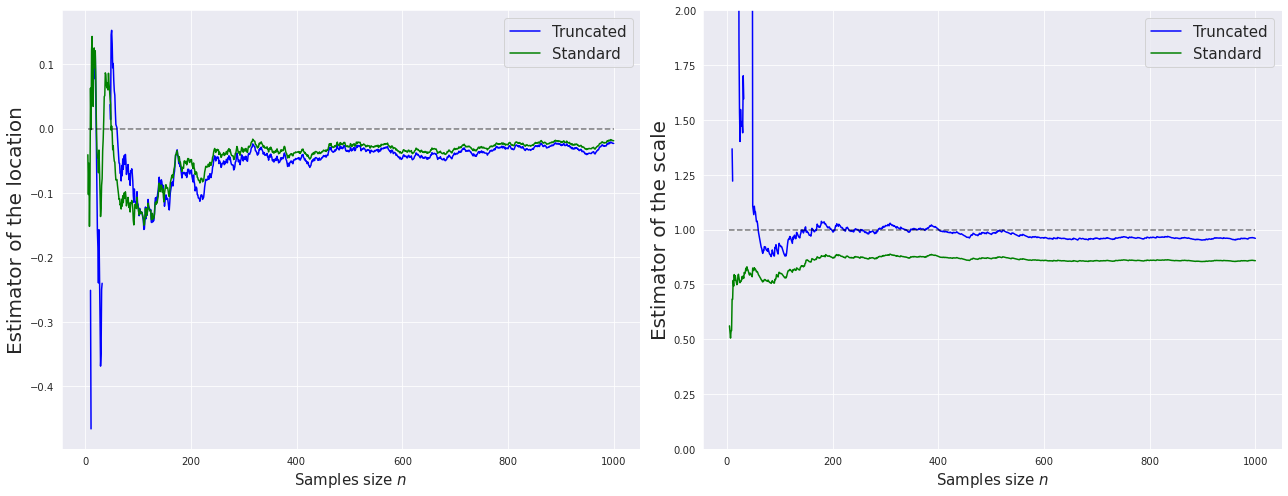

In [9]:
with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(figsize=(18, 7), nrows=1, ncols=2)
    
    nn = np.linspace(n_start, N, N - n_start + 1)
    
    ax = axes[0]
    ax.plot(nn, mu_hat, color='blue', label='Truncated')
    ax.plot(nn, mu_hat_standard, color='green', label='Standard')
    ax.plot(nn, np.repeat(mu, len(nn)), color='black', linestyle='dashed', alpha=0.5)
    ax.legend(loc='upper right', prop={'size': 15})
    ax.set_xlabel('Samples size $n$', fontsize=15)
    ax.set_ylabel('Estimator of the location', fontsize=20)
    
    ax = axes[1]
    ax.plot(nn, sigma_hat, color='blue', label='Truncated')
    ax.plot(nn, sigma_hat_standard, color='green', label='Standard')
    ax.plot(nn, np.repeat(sigma, len(nn)), color='black', linestyle='dashed', alpha=0.5)
    ax.set_ylim([0, 2 * sigma])
    ax.legend(loc='upper right', prop={'size': 15})
    ax.set_xlabel('Samples size $n$', fontsize=15)
    ax.set_ylabel('Estimator of the scale', fontsize=20)
        
    plt.tight_layout()
    plt.show()

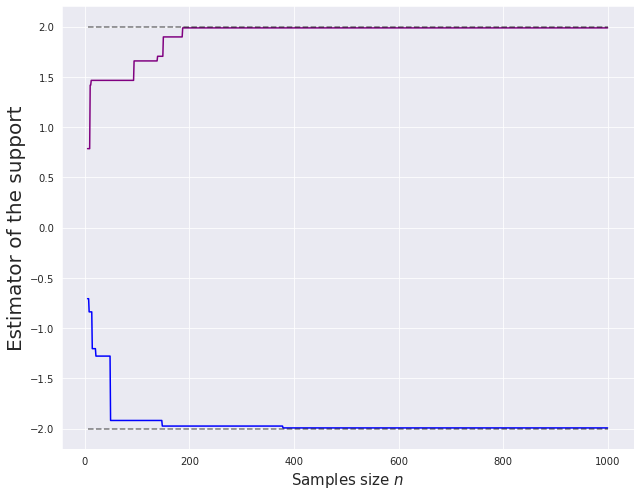

In [7]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(9, 7), nrows=1, ncols=1)

    ax.plot(nn, a, color='blue')
    ax.plot(nn, b, color='purple')
    ax.plot(nn, np.repeat(lower_bound, len(nn)), color='black', linestyle='dashed', alpha=0.5)
    ax.plot(nn, np.repeat(upper_bound, len(nn)), color='black', linestyle='dashed', alpha=0.5)
    ax.set_xlabel('Samples size $n$', fontsize=15)
    ax.set_ylabel('Estimator of the support', fontsize=20)
    
    plt.tight_layout()
    plt.show()

In [8]:
# with sns.axes_style('darkgrid'):
#     fig, ax = plt.subplots(figsize=(9, 7), nrows=1, ncols=1)
    
#     mu = 1 
#     sigma = 2
#     lo = 0
#     hi = 3
    
#     alpha = (lo - mu) / sigma
#     beta = (hi - mu) / sigma
#     Z = Phi(beta) - Phi(alpha)
    
#     xx = np.linspace(lo, hi, 1000)
#     ax.plot(xx, truncnorm(alpha, beta, loc=mu, scale=sigma).pdf(xx), color='blue')
#     ax.plot(xx, phi((xx - mu) / sigma) / (sigma * Z), color='green')
    
#     plt.tight_layout()
#     plt.show()